In [1]:
import scipy
import numpy as np
import matplotlib
import pandas as pd
import sklearn
import statsmodels
import bamboolib as bam
from statsmodels.tsa.seasonal import STL, seasonal_decompose
bam.disable()

The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian


In [2]:
file_name = 'maregraphie_csv_4_1954_1992.csv'

In [3]:
from pandas import read_csv
data_ = read_csv(file_name, header=0, index_col=0, parse_dates=True, squeeze=True)

In [4]:
maximum = 43818
data_.iloc[[maximum]]
# 26298 - 1956
# 43818 - 1958

,Valeur,Source
Date,,
1958-12-31 23:00:00,3.73,4


In [5]:
data_ = data_.drop(columns=['Source'])

In [6]:
data = data_[:maximum]
print(len(data))

43818


In [7]:
dfcol = ['Valeur']
data = data.resample('H').mean()
data

,Valeur
Date,
1954-01-01 00:00:00,5.10
1954-01-01 01:00:00,5.22
1954-01-01 02:00:00,5.04
1954-01-01 03:00:00,4.50
1954-01-01 04:00:00,3.91
...,...
1958-12-31 18:00:00,5.58
1958-12-31 19:00:00,6.15
1958-12-31 20:00:00,6.19


array([<AxesSubplot:xlabel='Date'>], dtype=object)

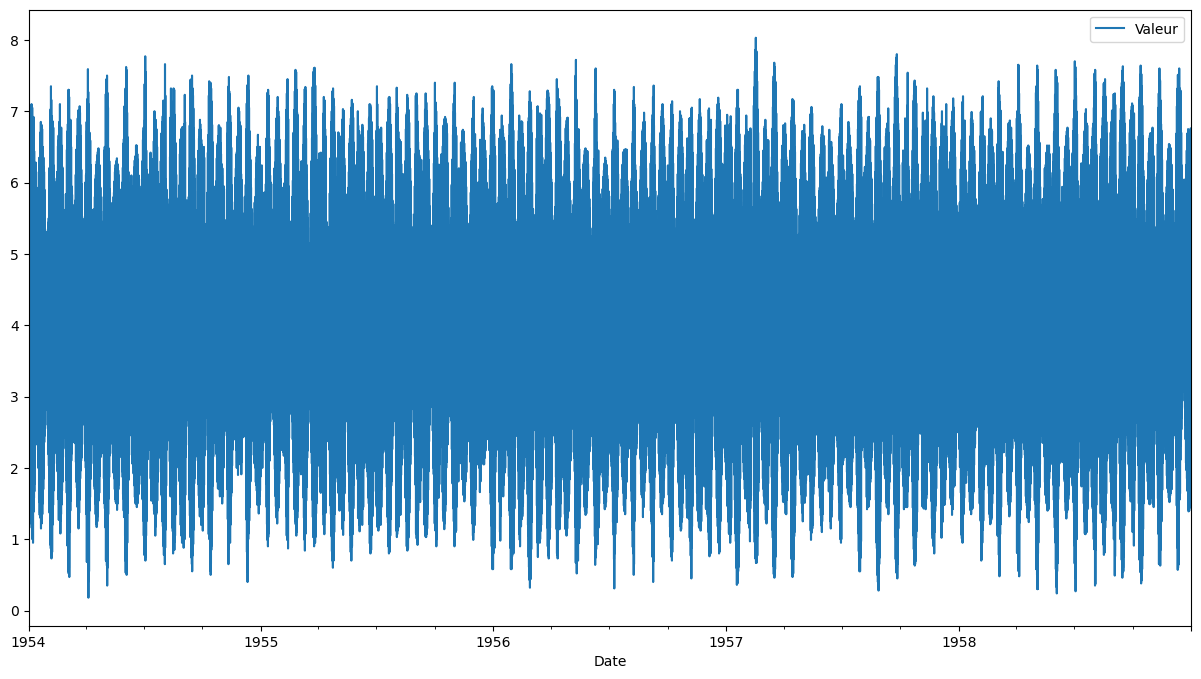

In [8]:
preprocessed = data.copy()
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp, period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = str(results.resid.index[i])
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
            
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.plot(figsize=(15, 8), subplots=True)

In [9]:
# We have to separate de data for years.
# For this problem one year is like one cycle.
split1 = pd.to_datetime('1957/12/31 23:00:00')
split2 = pd.to_datetime('1958/01/01')

train1 = preprocessed[:split1]
test1 = preprocessed[split2:]
train1

,Valeur
Date,
1954-01-01 00:00:00,5.10
1954-01-01 01:00:00,5.22
1954-01-01 02:00:00,5.04
1954-01-01 03:00:00,4.50
1954-01-01 04:00:00,3.91
...,...
1957-12-31 19:00:00,3.16
1957-12-31 20:00:00,3.68
1957-12-31 21:00:00,4.25


In [10]:
train = preprocessed[:split1]
test = preprocessed[split2:]

In [11]:
print(train)
print('-' * 50)
print(test)

                     Valeur
Date                       
1954-01-01 00:00:00    5.10
1954-01-01 01:00:00    5.22
1954-01-01 02:00:00    5.04
1954-01-01 03:00:00    4.50
1954-01-01 04:00:00    3.91
...                     ...
1957-12-31 19:00:00    3.16
1957-12-31 20:00:00    3.68
1957-12-31 21:00:00    4.25
1957-12-31 22:00:00    4.80
1957-12-31 23:00:00    5.22

[35064 rows x 1 columns]
--------------------------------------------------
                     Valeur
Date                       
1958-01-01 00:00:00    5.38
1958-01-01 01:00:00    5.28
1958-01-01 02:00:00    4.90
1958-01-01 03:00:00    4.37
1958-01-01 04:00:00    3.84
...                     ...
1958-12-31 18:00:00    5.58
1958-12-31 19:00:00    6.15
1958-12-31 20:00:00    6.19
1958-12-31 21:00:00    5.62
1958-12-31 22:00:00    4.70

[8759 rows x 1 columns]


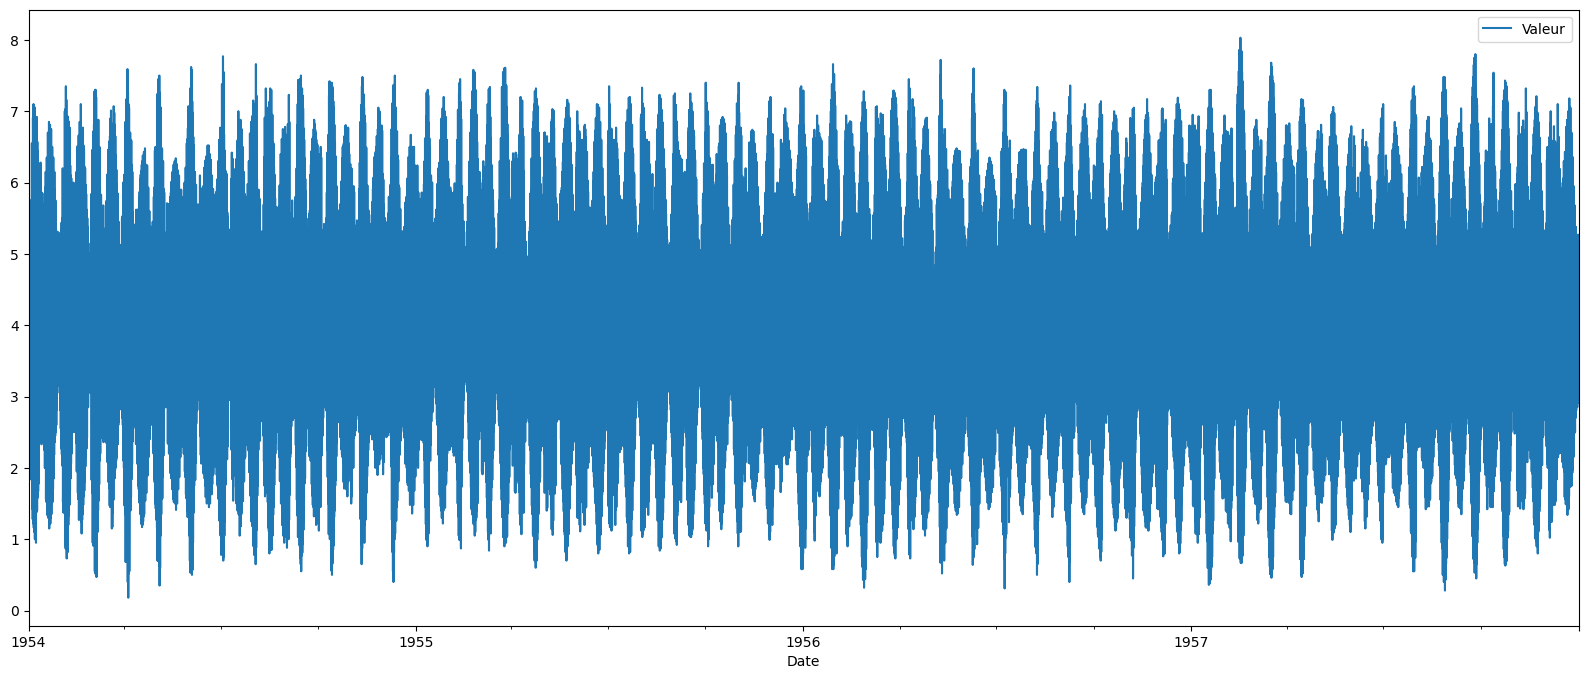

In [12]:
train.dropna(inplace=True)
test.dropna(inplace=True)
axes = train[dfcol].plot(figsize=(20, 8), subplots=True)

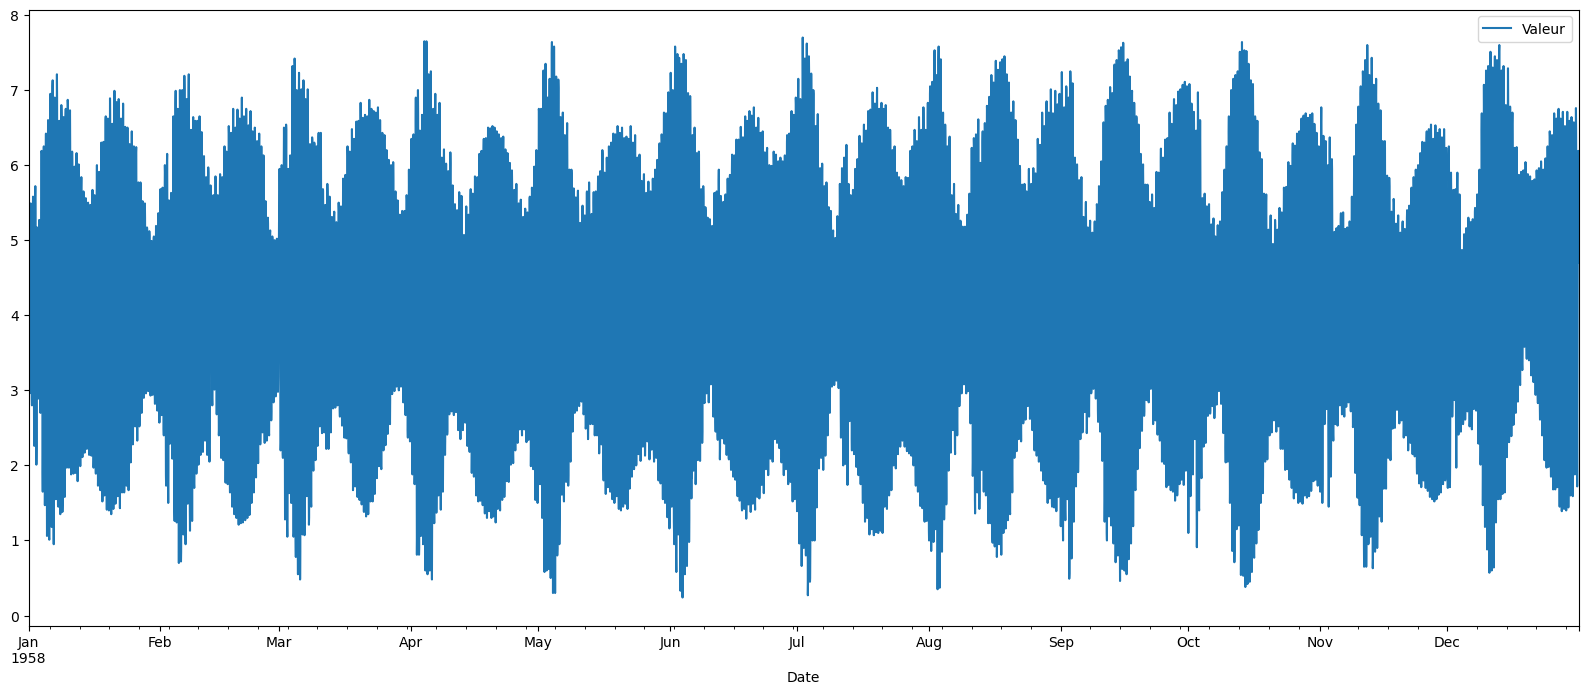

In [13]:
axes = test[dfcol].plot(figsize=(20, 8), subplots=True)

In [14]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

def timeseries_to_supervised(data, lag=1):
    """Frame a sequence data into a supervised learning problem, i.e., time sequence -> (X, y)"""
    df = DataFrame(data)  # DataFrame is a pandas class
    columns = [df.shift(i) for i in range(1, lag+1)]  # shift() pushed dataframe or a column vector downwards by i spaces
    columns.insert(0, df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df
# I haven't undertood this yet

In [15]:
train = timeseries_to_supervised(train, 24)
test = timeseries_to_supervised(test, 24)

In [16]:
test.to_csv('test.csv')
train.to_csv('train.csv')
train = read_csv('train.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
test = read_csv('test.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [17]:
test['Month'] = pd.DatetimeIndex(test.index).month
test['Hour'] = pd.DatetimeIndex(test.index).hour
test['Day'] = pd.DatetimeIndex(test.index).day

train['Month'] = pd.DatetimeIndex(train.index).month
train['Hour'] = pd.DatetimeIndex(train.index).hour
train['Day'] = pd.DatetimeIndex(train.index).day
train

,Valeur,Valeur.1,Valeur.2,Valeur.3,Valeur.4,Valeur.5,Valeur.6,Valeur.7,Valeur.8,Valeur.9,...,Valeur.18,Valeur.19,Valeur.20,Valeur.21,Valeur.22,Valeur.23,Valeur.24,Month,Hour,Day
Date,,,,,,,,,,,,,,,,,,,,,
1954-01-01 00:00:00,5.10,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1
1954-01-01 01:00:00,5.22,5.10,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,1,1
1954-01-01 02:00:00,5.04,5.22,5.10,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,2,1
1954-01-01 03:00:00,4.50,5.04,5.22,5.10,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,3,1
1954-01-01 04:00:00,3.91,4.50,5.04,5.22,5.10,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957-12-31 19:00:00,3.16,2.91,3.00,3.40,3.90,4.40,4.9,5.27,5.26,4.95,...,4.62,4.93,5.13,5.00,4.70,4.29,3.70,12,19,31
1957-12-31 20:00:00,3.68,3.16,2.91,3.00,3.40,3.90,4.4,4.90,5.27,5.26,...,4.14,4.62,4.93,5.13,5.00,4.70,4.29,12,20,31
1957-12-31 21:00:00,4.25,3.68,3.16,2.91,3.00,3.40,3.9,4.40,4.90,5.27,...,3.70,4.14,4.62,4.93,5.13,5.00,4.70,12,21,31


In [18]:
test1['Month'] = pd.DatetimeIndex(test1.index).month
test1['Hour'] = pd.DatetimeIndex(test1.index).hour
test1['Day'] = pd.DatetimeIndex(test1.index).day

train1['Month'] = pd.DatetimeIndex(train1.index).month
train1['Hour'] = pd.DatetimeIndex(train1.index).hour
train1['Day'] = pd.DatetimeIndex(train1.index).day
train1

,Valeur,Month,Hour,Day
Date,,,,
1954-01-01 00:00:00,5.10,1,0,1
1954-01-01 01:00:00,5.22,1,1,1
1954-01-01 02:00:00,5.04,1,2,1
1954-01-01 03:00:00,4.50,1,3,1
1954-01-01 04:00:00,3.91,1,4,1
...,...,...,...,...
1957-12-31 19:00:00,3.16,12,19,31
1957-12-31 20:00:00,3.68,12,20,31
1957-12-31 21:00:00,4.25,12,21,31


In [19]:
test = test.loc[(test['Hour'] == 0) | (test['Hour'] == 12)]
test1 = test1.loc[(test1['Hour'] == 0) | (test1['Hour'] == 12)]

In [20]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

Y_train = train.filter(dfcol, axis=1)
X_train = train.drop(columns=dfcol)
X_train = sc_X.fit_transform(X_train)
Y_train = sc_y.fit_transform(Y_train)

Y_test = test.filter(dfcol, axis=1)
X_test = test.drop(columns=dfcol)
X_test = sc_X.fit_transform(X_test)
Y_test = sc_y.fit_transform(Y_test)

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

mod = MultiOutputRegressor(SVR(kernel='rbf'), n_jobs=4)
model1 = mod.fit(X_train,Y_train)

In [22]:
y_pred = model1.predict(X_test)
y_new_inverse = sc_y.inverse_transform(y_pred)
y_inverse = sc_y.inverse_transform(Y_test)

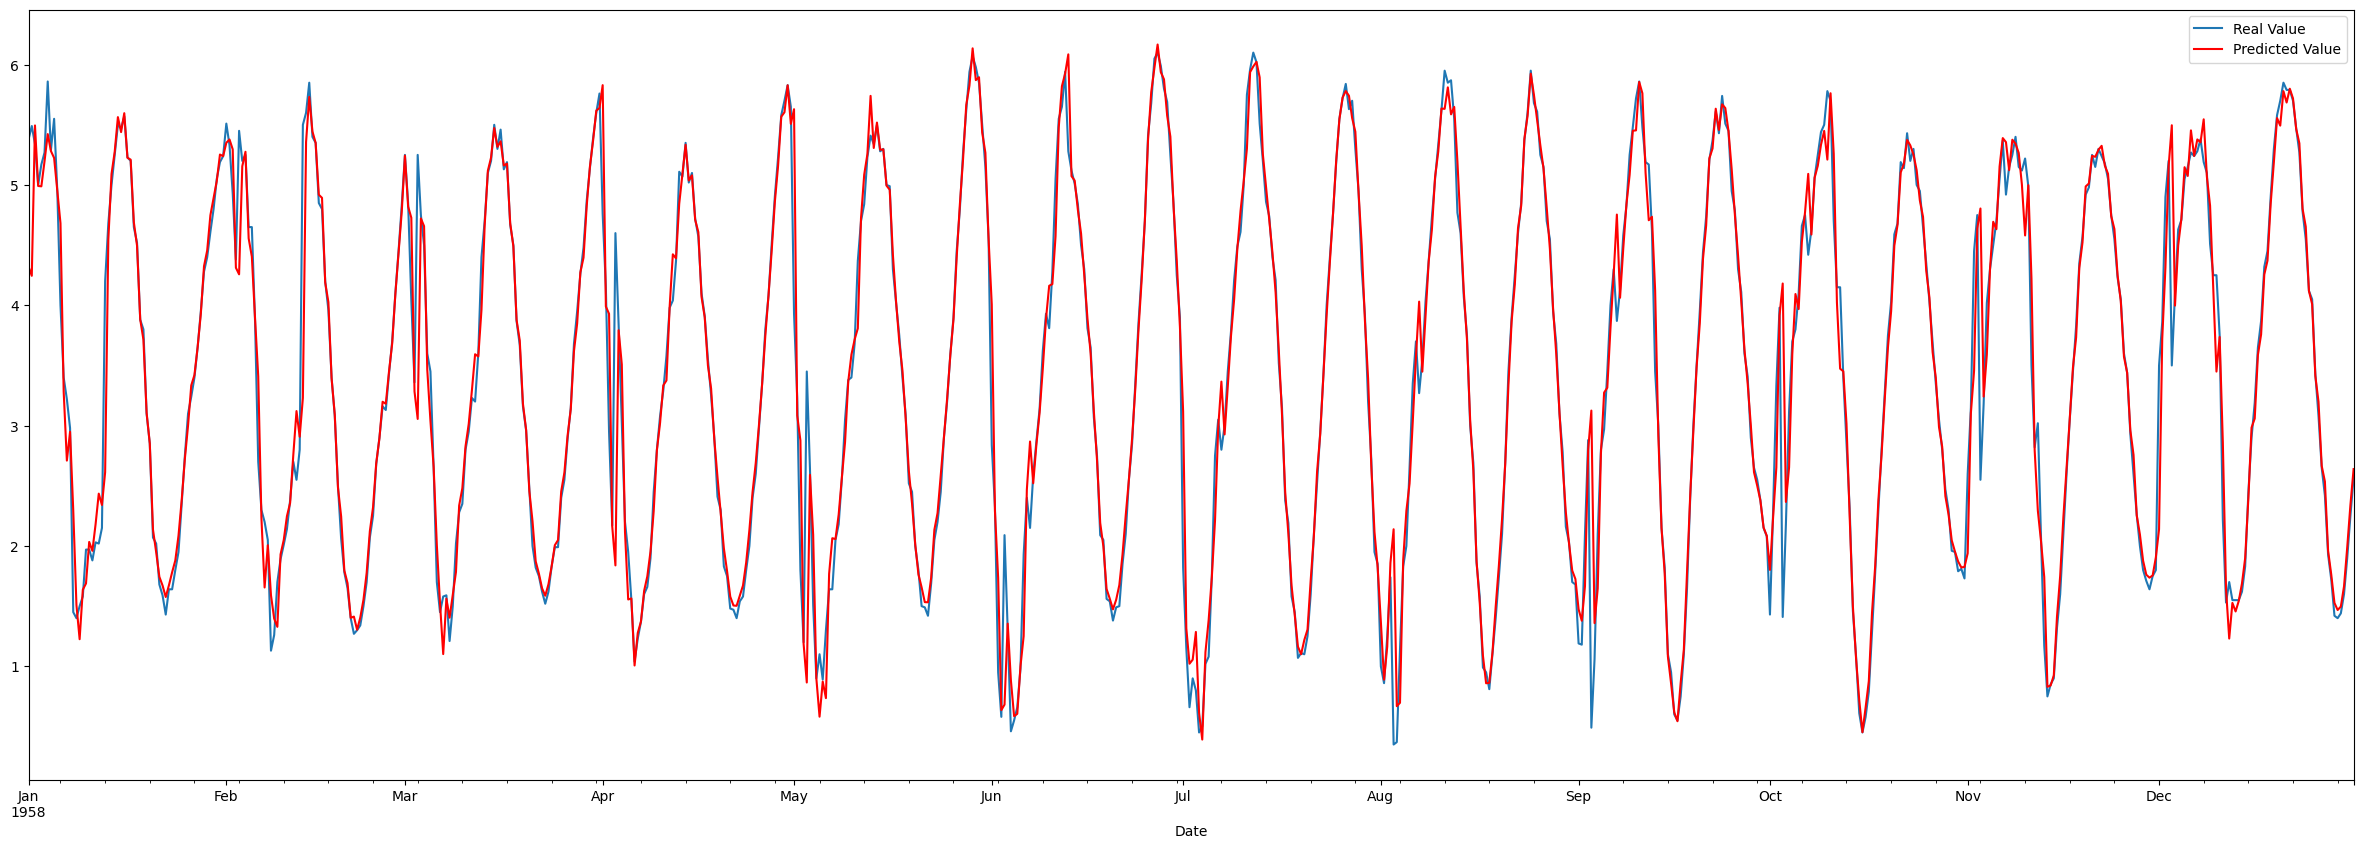

In [23]:
import matplotlib.pyplot as plt

test_dates = test.index
y_df = pd.DataFrame(y_inverse)
y_n_df = pd.DataFrame(y_new_inverse)
y_df.columns = dfcol
y_n_df.columns = dfcol
y_n_df.index = test_dates
y_df.index = test_dates
axes = y_df[dfcol].plot(figsize=(30, 10), subplots=True)
y_n_df[dfcol].plot(figsize=(30, 10), subplots=True, ax = axes, color='red')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('prediction_1958.png')

In [24]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error

def stats_model(model_num, plot_df, pred_df, num_target=1):
    """
    Function for predictions metrics
    """
    rmse = list()  # Mean Squared Error
    mse = list()  # root-mean-square error
    rsq2 = list()  # coefficient of determination
    MedAE = list()  # median_absolute_error
    MAE = list()  # mean_absolute_error
    MaxErr = list()  # max_error

    
    for i in range(0,num_target):
        m = mean_squared_error(plot_df.iloc[:,i], pred_df.iloc[:,i])
        rmse.append(np.sqrt(m))
        mse.append(m)
        rsq2.append(r2_score(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MAE.append(mean_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MedAE.append(median_absolute_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        MaxErr.append(max_error(plot_df.iloc[:,i], pred_df.iloc[:,i]))
        

    results = pd.DataFrame(mse)
    results.insert(1, 'RMSE', rmse) 
    results.insert(2, 'R^2', rsq2)
    results.insert(3, 'MAE', MAE)
    results.insert(4, 'MedAE', MedAE)
    results.insert(5, 'MaxErr', MaxErr)
    results.rename(columns = {0:'MSE'}, inplace = True) 
    results.to_csv('Model'+str(model_num)+'.csv')

In [25]:
stats_model(1, y_df, y_n_df, 1)

In [26]:
model1 = read_csv('Model1.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [27]:
model1

,MSE,RMSE,R^2,MAE,MedAE,MaxErr
0,0.134127,0.366233,0.943784,0.161769,0.065375,2.771175


<br>

<br>

### Trash

In [28]:
"""
sc_X1 = StandardScaler()
sc_y1 = StandardScaler()

Y_train1 = train['Valeur'].values.reshape(-1,1)
cols = [c for c in train.columns if c.lower()[:11] == 'valeur']
X_train1 = train[cols]
X_train1 = X_train1.drop(columns=['Valeur'])
Y_train1 = sc_y1.fit_transform(Y_train1)
X_train1 = sc_X1.fit_transform(X_train1)

Y_test1 = test['Valeur'].values.reshape(-1,1)
cols2 = [c for c in test.columns if c.lower()[:11] == 'valeur']
X_test1 = test[cols2]
X_test1 = X_test1.drop(columns=['Valeur'])
X_test1 = sc_X1.fit_transform(X_test1)
Y_test1 = sc_y1.fit_transform(Y_test1)
"""

"\nsc_X1 = StandardScaler()\nsc_y1 = StandardScaler()\n\nY_train1 = train['Valeur'].values.reshape(-1,1)\ncols = [c for c in train.columns if c.lower()[:11] == 'valeur']\nX_train1 = train[cols]\nX_train1 = X_train1.drop(columns=['Valeur'])\nY_train1 = sc_y1.fit_transform(Y_train1)\nX_train1 = sc_X1.fit_transform(X_train1)\n\nY_test1 = test['Valeur'].values.reshape(-1,1)\ncols2 = [c for c in test.columns if c.lower()[:11] == 'valeur']\nX_test1 = test[cols2]\nX_test1 = X_test1.drop(columns=['Valeur'])\nX_test1 = sc_X1.fit_transform(X_test1)\nY_test1 = sc_y1.fit_transform(Y_test1)\n"

In [29]:
"""
sc_x2 = StandardScaler()
sc_y2 = StandardScaler()

Y_train2 = train1['Valeur'].values.reshape(-1,1)
X_train2 = train1[dfcol].drop(columns=['Valeur'])
Y_train2 = sc_y2.fit_transform(Y_train2)
X_train2 = sc_x2.fit_transform(X_train2)

Y_test2 = test1['Valeur'].values.reshape(-1,1)
X_test2 = test1[dfcol].drop(columns=['Valeur'])
X_test2 = sc_x2.fit_transform(X_test2)
Y_test2 = sc_y2.fit_transform(Y_test2)
X_test2.shape
"""

"\nsc_x2 = StandardScaler()\nsc_y2 = StandardScaler()\n\nY_train2 = train1['Valeur'].values.reshape(-1,1)\nX_train2 = train1[dfcol].drop(columns=['Valeur'])\nY_train2 = sc_y2.fit_transform(Y_train2)\nX_train2 = sc_x2.fit_transform(X_train2)\n\nY_test2 = test1['Valeur'].values.reshape(-1,1)\nX_test2 = test1[dfcol].drop(columns=['Valeur'])\nX_test2 = sc_x2.fit_transform(X_test2)\nY_test2 = sc_y2.fit_transform(Y_test2)\nX_test2.shape\n"

In [30]:
"""
param = {'kernel' : ['rbf'],'C' : [1,5],'gamma' : ('auto','scale')}
mod2 = GridSearchCV(SVR(),param,cv=5,n_jobs=4)
model3 = mod2.fit(X_train2,Y_train2)
"""

"\nparam = {'kernel' : ['rbf'],'C' : [1,5],'gamma' : ('auto','scale')}\nmod2 = GridSearchCV(SVR(),param,cv=5,n_jobs=4)\nmodel3 = mod2.fit(X_train2,Y_train2)\n"

In [31]:
"""
mod1 = SVR(kernel='rbf')
model2 = mod1.fit(X_train1,Y_train1)
"""

"\nmod1 = SVR(kernel='rbf')\nmodel2 = mod1.fit(X_train1,Y_train1)\n"

In [32]:
"""
y_pred1 = model2.predict(X_test1)
y_new_inverse1 = sc_y1.inverse_transform(y_pred1)
y_inverse1 = sc_y1.inverse_transform(Y_test1)
"""

'\ny_pred1 = model2.predict(X_test1)\ny_new_inverse1 = sc_y1.inverse_transform(y_pred1)\ny_inverse1 = sc_y1.inverse_transform(Y_test1)\n'

In [33]:
"""
y_pred2 = model3.predict(X_test2)
y_new_inverse2 = sc_y2.inverse_transform(y_pred2)
y_inverse2 = sc_y2.inverse_transform(Y_test2)
"""

'\ny_pred2 = model3.predict(X_test2)\ny_new_inverse2 = sc_y2.inverse_transform(y_pred2)\ny_inverse2 = sc_y2.inverse_transform(Y_test2)\n'